# GPU adaptation of flexOPT.jl

In [105]:
# Nobuaki Fuji @ipgp September 2025
using Pkg

cd(@__DIR__)
Pkg.activate("../..")
using BenchmarkTools
# below are the tools to debug the code
#using Revise # if we use Revise, include will be Revise.includet
using Profile, StatProfilerHTML

using Metal

include("../src/imageReader.jl") # read 2D images for models

include("../src/OPTwrappers.jl") 
include("../src/OPTnewEngines.jl")  # I do this to test

include("../src/batchGPU.jl") # now indispensable for >3D problem for Coef computation


→ Using Metal backend (1

  Activating project at `~/Documents/Github/flexibleDSM`


 device(s))
Selected backend type: MetalBackend


In [106]:
in_vscode  = get(ENV, "VSCODE_PID", nothing) !== nothing

true

In [107]:
iExperiment = 1

# 'iExperiment' can be fixed to be 1, or nothing if the user does not need to perform benchmark tests
# (which should be the case for the most of the time when the software gets stabilised)

1

In [108]:
famousEquationType="2DacousticTime"
exprs,fields,vars,extexprs,extfields,extvars,coordinates,∂,∂²=famousEquations(famousEquationType)

(Differential(t)(Differential(t)(u(x, y, t))) - (Differential(x)(Differential(x)(u(x, y, t))) + Differential(y)(Differential(y)(u(x, y, t))))*(v(x, y)^2), u(x, y, t), v(x, y), f(x, y, t), f(x, y, t), 1, (x, y, t), Any[Differential(x), Differential(y), Differential(t)], Any[Differential(x) ∘ Differential(x), Differential(y) ∘ Differential(y), Differential(t) ∘ Differential(t)])

In [109]:
modelName="marmousi"

modelDefinitionMethod="2DimageFile" # ToyModel or 2DimageFile (or 1DsphericalPlanet)
model =nothing


if modelDefinitionMethod !== nothing
        
    #region Model input - option i) Model domain definition

    if modelDefinitionMethod === "ToyModel"
        DomainWindow=(DomainWindowT=1.0,DomainWindowX=1.0,DomainWindowY=1.0,DomainWindowZ=1.0)
        ModelSizeTXYZ=(ModelSizeT=101,ModelSizeX=101,ModelSizeY=101,ModelSizeZ=0)
    end

    #endregion

    #region Model input - option ii) Read a file (2D or 3D) and define Δs

    if modelDefinitionMethod === "2DimageFile"

        #imagefile="../data/model/random/colourful.jpg"
        #imagefile="../data/model/artemis/IMG_6098.jpeg"
        #imagefile="../data/model/random/tmp.png"
        imagefile = "../data/model/random/marmousi.png"
        colormap = "jet" #colormap can be RGB vector or predefined colormap

        #model=read2DimageModel(imagefile,colormap;Nwidth=10,Nheight=10,showRecoveredImage=false)
        model=read2DimageModel(imagefile,colormap;showRecoveredImage=false)
    end
    #endregion

    #region Model input - option iii) Read a file (1D spherical planet models)

    if modelDefinitionMethod ==="1DsphericalPlanet"
        # use some programmes that are developed during Xmas 2023
        # inputModels.jl
    end

#endregion
end

In [110]:
@show Nz,Nx=size(model)
Δz,Δx=(1.0,1,0)

(Nz, Nx) = size(model) = (676, 802)


(1.0, 1, 0)

In [111]:
# I don't know why the backend becomes GLMakie without this ... need to check

using CairoMakie
CairoMakie.activate!()

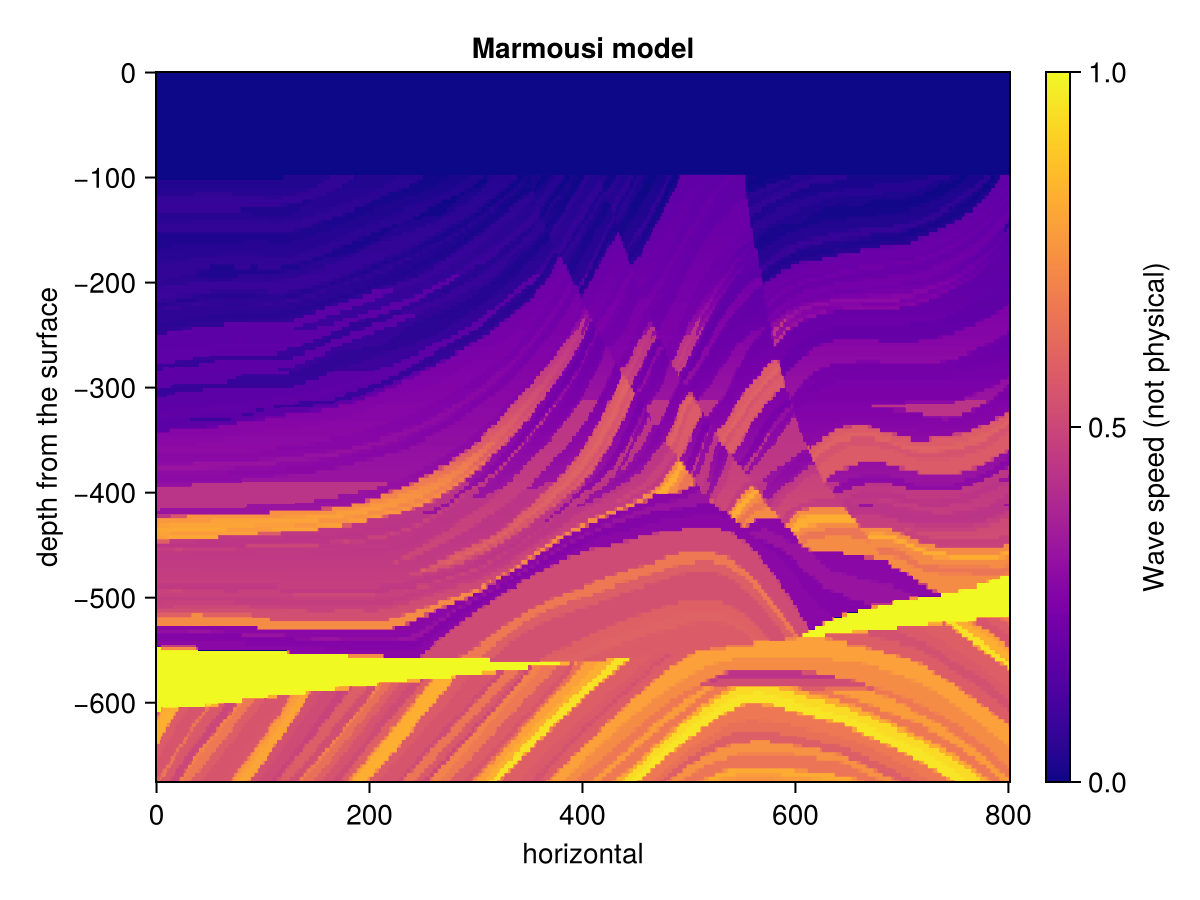

In [112]:
fig, ax, hm = heatmap(
    #topo.x,topo.y,topo.z';
    collect((0:1:(Nx-1)).*Δx),(collect(-(Nz-1)).*Δz:1:0), reverse(model',dims=2);
    colormap = :plasma,
    colorrange=(extrema(model)),
    axis = (xlabel = "horizontal", ylabel = "depth from the surface", title = "Marmousi model")
)
#ylims!(ax,-200,300)
#xlims!(ax,0,400)
Colorbar(fig[1,2], hm, label="Wave speed (not physical)")
fig

In [113]:
coordinates

(x, y, t)

In [114]:
Δnum = (1.0,1.0,1.0) # this should be in the same order as coordinates 



IneedExternalSources = true
maskedRegionForSourcesInSpace = nothing

#DrWatson configurations

orderBtime=1
orderBspace=1
pointsInSpace=2
pointsInTime=2

WorderBspace=1
WorderBtime=1
supplementaryOrder=2

2

In [115]:
models=[] # you might need to make this empty tuple first, otherwise one-member tuple can be misinterpreted
models=push!(models, (model .* 0.2 .+ 0.4))

1-element Vector{Any}:
 [0.4 0.4 … 0.4 0.4; 0.4 0.4 … 0.4 0.4; … ; 0.5138386099547898 0.5163891573813251 … 0.5501948972360029 0.5472638856339349; 0.5300777283024765 0.5308589172720881 … 0.5545259469249547 0.5545259469249547]

In [116]:
maximum(models[1])

0.6000000000000001

In [117]:
fakeNt = 1
timeMarching = any(a -> a === timeDimensionString, string.(coordinates)) 
if timeMarching
    fakeNt = pointsInTime+1
    modelPoints = (size(model)...,fakeNt) # Nx, Ny etc thing. Nt is also mentioned and it should be the last element!
else
    modelPoints = (size(model))
end

(676, 802, 3)

In [118]:
maskedRegionForSourcesInSpace  = Array{CartesianIndex,1}(undef,0) # it is important to decalre the type of this
maskedRegionForSourcesInSpace = push!(maskedRegionForSourcesInSpace, CartesianIndex(modelPoints[1:end-1].÷2))# in Ndimension (or Ndimension  - 1 if timeMarching)
# in this example, I put a point source at the centre of the model space

forceModels =((1.0)) # if your model does not have anything special material parameters then it's how it's written

concreteModelParameters = @strdict famousEquationType Δnum orderBtime orderBspace WorderBtime WorderBspace supplementaryOrder pointsInSpace pointsInTime IneedExternalSources modelName models modelPoints forceModels maskedRegionForSourcesInSpace iExperiment

Dict{String, Any} with 16 entries:
  "IneedExternalSources"          => true
  "models"                        => Any[[0.4 0.4 … 0.4 0.4; 0.4 0.4 … 0.4 0.4;…
  "maskedRegionForSourcesInSpace" => CartesianIndex[CartesianIndex(338, 401)]
  "iExperiment"                   => 1
  "orderBtime"                    => 1
  "Δnum"                          => (1.0, 1.0, 1.0)
  "pointsInSpace"                 => 2
  "WorderBspace"                  => 1
  "pointsInTime"                  => 2
  "WorderBtime"                   => 1
  "supplementaryOrder"            => 2
  "orderBspace"                   => 1
  "modelPoints"                   => (676, 802, 3)
  "forceModels"                   => 1.0
  "modelName"                     => "marmousi"
  "famousEquationType"            => "2DacousticTime"

In [119]:
#safeget(A, inds...; default=0) = checkbounds(Bool, A, inds...) ? A[inds...] : default

In [120]:
# we need to see what's happening inside makeCompleteCostFunctions

In [121]:
    @unpack famousEquationType, Δnum, orderBtime, orderBspace, WorderBtime,WorderBspace,supplementaryOrder,pointsInSpace, pointsInTime, IneedExternalSources, modelName, models, modelPoints, forceModels,maskedRegionForSourcesInSpace, iExperiment = concreteModelParameters
    exprs,fields,vars,extexprs,extfields,extvars,coordinates,∂,∂² = famousEquations(famousEquationType)
    global ∂,∂²
    
    # here we construct semi symbolic operators (with numerical Δnum)
    operatorConfigurations = @strdict famousEquationType Δnum orderBtime orderBspace WorderBtime WorderBspace supplementaryOrder pointsInSpace pointsInTime IneedExternalSources iExperiment


Dict{String, Any} with 11 entries:
  "IneedExternalSources" => true
  "iExperiment"          => 1
  "orderBtime"           => 1
  "Δnum"                 => (1.0, 1.0, 1.0)
  "pointsInSpace"        => 2
  "WorderBspace"         => 1
  "pointsInTime"         => 2
  "WorderBtime"          => 1
  "supplementaryOrder"   => 2
  "orderBspace"          => 1
  "famousEquationType"   => "2DacousticTime"

In [122]:
#instead of doing this, I go step by step to see what's happening
#operators = myProduceOrLoad(OPTobj,operatorConfigurations,"semiSymbolics")

In [123]:
 @unpack famousEquationType, Δnum, orderBtime, orderBspace, WorderBtime,WorderBspace,supplementaryOrder,pointsInSpace, pointsInTime,IneedExternalSources, iExperiment= operatorConfigurations

exprs,fields,vars,extexprs,extfields,extvars,coordinates,∂,∂² = famousEquations(famousEquationType)

TaylorOptions=(WorderBtime=WorderBtime,WorderBspace=WorderBspace,supplementaryOrder=supplementaryOrder)
trialFunctionsCharacteristics=(orderBtime=orderBtime,orderBspace=orderBspace,pointsInSpace=pointsInSpace,pointsInTime=pointsInTime)

(orderBtime = 1, orderBspace = 1, pointsInSpace = 2, pointsInTime = 2)

In [124]:
# instead of doing below
#@time operatorData=OPTobj(exprs,fields,vars; coordinates=coordinates,trialFunctionsCharacteristics=trialFunctionsCharacteristics,TaylorOptions=TaylorOptions,Δnum = Δnum,iExperiment=iExperiment)

In [125]:
# here is the internal contents of OPTobj(exprs,fields,vars; coordinates=coordinates,trialFunctionsCharacteristics=trialFunctionsCharacteristics,TaylorOptions=TaylorOptions,Δnum = Δnum,iExperiment=iExperiment)

In [126]:


    @show timeMarching = any(a -> a === timeDimensionString, string.(coordinates))


    @unpack orderBtime, orderBspace, pointsInSpace, pointsInTime = trialFunctionsCharacteristics
    @unpack WorderBtime, WorderBspace,supplementaryOrder = TaylorOptions

    NtypeofExpr=length(exprs)   # number of governing equations
    NtypeofMaterialVariables=length(vars) # number of material coefficients
    NtypeofFields=length(fields) # number of unknown fields
    
    Ndimension = length(coordinates) # we do not change this for the moment, especially for the time-marching scheme
    pointsUsed = ones(Int, Ndimension).*(pointsInSpace+1)
    if timeMarching
        pointsUsed[end]=pointsInTime+1
    end


    if length(Δnum) !== Ndimension && !CˡηSymbolicInversion
        @error "the numerical delta increment has not the same dimension!"
    end

timeMarching = any((a->begin
                #= /Users/nobuaki/Documents/Github/flexibleDSM/OPTmotors/myOwnApplications/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sZmlsZQ==.jl:3 =#
                a === timeDimensionString
            end), string.(coordinates)) = true


In [127]:
 #region investigation of all the fields and vars dependencies in terms of x-y-z-t

    variableDependency=ones(Int,Ndimension)
    fieldDependency=ones(Int,Ndimension)
    eachVariableDependency=ones(Int,Ndimension,NtypeofMaterialVariables) 
    eachFieldDependency=ones(Int,Ndimension,NtypeofFields)
  
    for iFields in 1:NtypeofFields
        eachFieldDependency[:,iFields]=findCartesianDependency(fields[iFields],Ndimension)
        fieldDependency = fieldDependency .* (ones(Int,Ndimension).-eachFieldDependency[:,iFields])
    end


    for iVars in 1:NtypeofMaterialVariables
        eachVariableDependency[:,iVars]=findCartesianDependency(vars[iVars],Ndimension)
        variableDependency = variableDependency .* (ones(Int,Ndimension).-eachVariableDependency[:,iVars])
    end

    

    fieldDependency = ones(Int,Ndimension).-fieldDependency
    variableDependency = ones(Int,Ndimension).-variableDependency

    # here we correct variableDependency with fieldDependency: if fieldDependency is zero then we do not take care of that dimension for the variables
    variableDependency = variableDependency .* fieldDependency

    #endregion

3-element Vector{Int64}:
 1
 1
 0

In [128]:
#region definition of points in time and space to be used

    # heaviside(x) = x > 0 ? 1 : x == 0 ? 0 : -1

    # the orders of B-spline functions, depending on fields 

    orderBspline=zeros(Int,Ndimension)
    WorderBspline=zeros(Int,Ndimension)

    if timeMarching
        orderBspline[Ndimension]=orderBtime*fieldDependency[Ndimension]
        orderBspline[1:Ndimension-1]=orderBspace*fieldDependency[1:Ndimension-1]
        WorderBspline[Ndimension]=WorderBtime*fieldDependency[Ndimension]
        WorderBspline[1:Ndimension-1]=WorderBspace*fieldDependency[1:Ndimension-1]
    else
        orderBspline[1:Ndimension]=orderBspace*fieldDependency[1:Ndimension]
        WorderBspline[1:Ndimension]=WorderBspace*fieldDependency[1:Ndimension]
    end
    
    # the maximum number of points used in the vicinity of the node, which is independent of the order of B-spline functions (see our paper)
    pointsUsedForFields=(pointsUsed.-1).*fieldDependency.+1

    # orderExpressions is the maximal orders of partials that we could expect in the expressions
    orderExpressions=pointsUsedForFields
    
    # numbers of points to evaluate the integral for the governing equation filtered by the test functions
    
    # orderU is the maximum orders for the fields that we will use for OPT coefficients' exploration
    orderU = (orderExpressions .-1) .+ (supplementaryOrder .*fieldDependency).+1 
    # we restore this orderU since we need to control this 

    #endregion

3-element Vector{Int64}:
 5
 5
 5

In [129]:
#region analysis of expressions to obtain the α_{n'nji}

    bigα=Array{Any,2}(missing,NtypeofFields,NtypeofExpr)
    varM=nothing
    for iExpr in eachindex(exprs)
        for iField in eachindex(fields)
            
            tmpNonZeroAlphas=PDECoefFinder(orderExpressions,coordinates,exprs[iExpr],fields[iField],vars) 
            # we assume that the pointsUsedForFields represent the highest order of partials
            bigα[iField,iExpr]=unique(tmpNonZeroAlphas)
        end
    end
    varM=varMmaker(pointsUsedForFields,coordinates,vars)
    @show bigα,varM
    #endregion


(bigα, varM) = (Any[Any[(node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(3, 1, 1)), (node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 3, 1)), (node = 1, nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 1, 3))];;], Any[v₁ v₂ v₃ v₄ v₅ v₆ v₇ v₈ v₉ v₁ v₂ v₃ v₄ v₅ v₆ v₇ v₈ v₉ v₁ v₂ v₃ v₄ v₅ v₆ v₇ v₈ v₉])


(Any[Any[(node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(3, 1, 1)), (node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 3, 1)), (node = 1, nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 1, 3))];;], Any[v₁ v₂ … v₈ v₉])

In [130]:

    #region Preparation for Taylor expansion
    
    orderTaylors=Array{Any,Ndimension}(undef,Tuple(orderU))
    pointsInSpaceTime=Array{Any,Ndimension}(undef,Tuple(pointsUsedForFields))
    
    
    multiOrdersIndices=CartesianIndices(orderTaylors)

    availablePointsConfigurations = Array{Array{Vector{Int64},Ndimension},1}()
    centrePointConfigurations=Array{Int64,1}()

    #endregion


Int64[]

In [131]:

    #region Cartesian indices that can be available to use (normally: iGeometry=1)

    multiPointsIndices=CartesianIndices(pointsInSpaceTime)
    # this is the whole local Cartesian grids (without any lacking points)
    
    tmpVecForMiddlePoint = ((car2vec(multiPointsIndices[end]).-1 ).÷2 ).+1 # only valid for testOnlyCentre
    midTimeCoord = nothing
    if timeMarching
        midTimeCoord=car2vec(multiPointsIndices[end])[end]-1
        tmpVecForMiddlePoint[end]=midTimeCoord
        #AjiννᶜU = Array{Num,2}(undef,length(multiPointsIndices)÷(midTimeCoord+1),NtypeofExpr)
    end
    #@show tmpVecForMiddlePoint 
    middleν=vec2car(tmpVecForMiddlePoint)

    @show availablePointsConfigurations=push!(availablePointsConfigurations,car2vec.(multiPointsIndices))
    centrePointConfigurations=push!(centrePointConfigurations,LinearIndices(multiPointsIndices)[middleν])
    @show size(availablePointsConfigurations)
    #endregion

availablePointsConfigurations = push!(availablePointsConfigurations, car2vec.(multiPointsIndices)) = [[[1, 1, 1] [1, 2, 1] [1, 3, 1]; [2, 1, 1] [2, 2, 1] [2, 3, 1]; [3, 1, 1] [3, 2, 1] [3, 3, 1];;; [1, 1, 2] [1, 2, 2] [1, 3, 2]; [2, 1, 2] [2, 2, 2] [2, 3, 2]; [3, 1, 2] [3, 2, 2] [3, 3, 2];;; [1, 1, 3] [1, 2, 3] [1, 3, 3]; [2, 1, 3] [2, 2, 3] [2, 3, 3]; [3, 1, 3] [3, 2, 3] [3, 3, 3]]]
size(availablePointsConfigurations) = (1,)


(1,)

In [132]:
CˡηSymbolicInversion=false
testOnlyCentre=true
iExperiment =nothing

In [133]:
 #region obtaining the semi-symbolic expression of cost function based on A given by eqns. 52 and 53.

    # before calling AuSymbolic we can manipulate pointsIndices for various boundary configurations


    if CˡηSymbolicInversion # this seems super cool but it takes time
        #Cˡη,Δ,multiLCar = illposedTaylorCoefficientsInversion(coordinates,multiOrdersIndices,multiPointsIndices;testOnlyCentre=testOnlyCentre,timeMarching=timeMarching)
        Δ = Symbolics.variables(:Δ,1:Ndimension)
    else
        Δ = Δnum
    end

    AjiννᶜU=[]
    Ulocal=[]



    @show typeof(Δ)
    @show typeof(Δ) <: Tuple{Vararg{Float64}}
    @show typeof(coordinates) <:Tuple{Vararg{Num}}

typeof(Δ) = Tuple{Float64, Float64, Float64}
typeof(Δ) <: Tuple{Vararg{Float64}} = true
typeof(coordinates) <: Tuple{Vararg{Num}} = true


true

In [134]:
iConfigGeometry=1

1

In [135]:
       @show pointsIndices=availablePointsConfigurations[iConfigGeometry]
        @show middleLinearν=centrePointConfigurations[iConfigGeometry]
        

        

        #tmpAjiννᶜU,tmpUlocal=ASemiSymbolic(coordinates,multiOrdersIndices,pointsIndices,multiPointsIndices,middleLinearν,Δ,varM,bigα,orderBspline,WorderBspline,NtypeofExpr,NtypeofFields)



        #varM is given above for the max number of points used 
        #tmpAjiννᶜU,tmpUlocal=AuSymbolic(coordinates,multiOrdersIndices,pointsIndices,multiPointsIndices,middleLinearν,Δ,varM,bigα,orderBspline,WorderBspline,NtypeofExpr,NtypeofFields)
        #AjiννᶜU=push!(AjiννᶜU,tmpAjiννᶜU)
        #Ulocal=push!(Ulocal,tmpUlocal)

pointsIndices = availablePointsConfigurations[iConfigGeometry] = [[1, 1, 1] [1, 2, 1] [1, 3, 1]; [2, 1, 1] [2, 2, 1] [2, 3, 1]; [3, 1, 1] [3, 2, 1] [3, 3, 1];;; [1, 1, 2] [1, 2, 2] [1, 3, 2]; [2, 1, 2] [2, 2, 2] [2, 3, 2]; [3, 1, 2] [3, 2, 2] [3, 3, 2];;; [1, 1, 3] [1, 2, 3] [1, 3, 3]; [2, 1, 3] [2, 2, 3] [2, 3, 3]; [3, 1, 3] [3, 2, 3] [3, 3, 3]]
middleLinearν = centrePointConfigurations[iConfigGeometry] = 14


14

In [136]:
# here below I make a fully GPU optimised version of A semi-symbolic construction  

In [174]:
function AmatrixSemiSymbolicGPU(coordinates,multiOrdersIndices,pointsIndices,multiPointsIndices,middleLinearν,Δ,varM,bigα,orderBspline,WorderBspline,NtypeofExpr,NtypeofFields;threads = 256,backend=backend)

    #region preparation

    

    # this is fully GPU optimised version of ASymbolic 
    nCoordinates = length(coordinates)
    nPoints = length(pointsIndices)
    nLs = length(multiOrdersIndices)
    # normally we put only the centre points (in the present time)
    # but the boundary condition requires some points a bit more challenging
    νIndices=[pointsIndices[middleLinearν]]
    # νIndices can be pointsIndices if one needs to look for
    # boundary operators

    L_MINUS_N = multiOrdersIndices
    L_MINUS_N = L_MINUS_N .-L_MINUS_N[1]
    # here L_MINUS_N is truly \mathbf{l}-\mahtbf{n} ∈ \mathbb{Z}_{≥0}

    #endregion

    #region we compute the integral of WYYKK in 1D domain (μ ∈ \mathbb{Z}/2 has not yet been implemented)

    integral1DWYYKK = Array{Any,1}(undef,nCoordinates)
    modifiedμ=Array{Any,1}(undef,nCoordinates)
    for iCoord in eachindex(coordinates) # for each 
        integralParams = @strdict oB =orderBspline[iCoord] oWB = WorderBspline[iCoord] νCoord=pointsIndices[middleLinearν][iCoord] LCoord = multiPointsIndices[end][iCoord] ΔCoord=Δ[iCoord] l_n_max=L_MINUS_N[end][iCoord]
        output = myProduceOrLoad(getIntegralWYYKK,integralParams,"intKernel")
        integral1DWYYKK[iCoord] = output["intKernelforνLΔ"]
        modifiedμ[iCoord] = output["modμ"] # this can be still 'nothing'
    end



    #endregion

    #region get CˡηGlobal (for ν)

    coefInversionDict = @strdict coordinates multiOrdersIndices pointsIndices Δ WorderBspline modifiedμ

    #@show coordinates multiOrdersIndices pointsIndices Δ WorderBspline modifiedμ

    output=myProduceOrLoad(TaylorCoefInversion,coefInversionDict,"taylorCoefInv")
    Cˡη=output["CˡηGlobal"]

    #endregion 

    #region objectives (Ajiννᶜ)

    # the order is: (νᶜ,) ν, i, j  here
    Ajiννᶜ = Array{Num,4}(undef,nPoints,nPoints,NtypeofFields,NtypeofExpr)

    # but this will already include bigα so the coefficients for each α_{nn'ji} should be given here

    #endregion

    #region useful LinearIndices conversion functions
    
    LI_points = LinearIndices(pointsIndices)
    LI_L_MINUS_N_plus_1 = LinearIndices(L_MINUS_N.+vec2car(ones(Int,nCoordinates)))
  
    #endregion


    #region make the table for each (x',x,n',n) (x=η+μ)
    nTotalSmallα = sum(length(bigα[iExpr, iField]) for iExpr in 1:NtypeofExpr, iField in 1:NtypeofFields)

    tableForLoop = Array{Int32,3}(undef,2+nCoordinates*2,nLs*nLs,nTotalSmallα) # for every α it will give the l and l-n
    
    fill!(tableForLoop, 0)
    indexLinearα = 1
    for iExpr ∈ 1:NtypeofExpr,iField ∈ 1:NtypeofFields
        
        α = bigα[iExpr,iField]
        for eachα ∈ α
            nᶜ = eachα.nᶜ - vec2car(ones(Int,nCoordinates))
            n = eachα.n - vec2car(ones(Int,nCoordinates))
            #nodeValue = eachα.node # not important at this point
            # Available indices
            Lᶜ_avail = (nᶜ .+ L_MINUS_N) ∩ L_MINUS_N
            L_avail = (n .+ L_MINUS_N) ∩ L_MINUS_N
            Lᶜ_Nᶜ_avail = Lᶜ_avail .- nᶜ
            L_N_avail = L_avail .- n
            
            iL=1
            for lᶜ ∈ Lᶜ_avail, l ∈ L_avail
                
                tableForLoop[1,iL,indexLinearα]= LI_L_MINUS_N_plus_1[lᶜ+vec2car(ones(Int,nCoordinates))]
                tableForLoop[2,iL,indexLinearα]= LI_L_MINUS_N_plus_1[l+vec2car(ones(Int,nCoordinates))]
                #tableForLoop[3,iL,indexLinearα]= LI_L_MINUS_N_plus_1[lᶜ-nᶜ+vec2car(ones(Int,nCoordinates))]
                #tableForLoop[4,iL,indexLinearα]= LI_L_MINUS_N_plus_1[l-n+vec2car(ones(Int,nCoordinates))]
                tmplᶜ_nᶜ = lᶜ-nᶜ+vec2car(ones(Int,nCoordinates))
                tmpl_n = l-n+vec2car(ones(Int,nCoordinates))
                for iCoord ∈ 1:nCoordinates
                    tableForLoop[2+iCoord,iL,indexLinearα] = tmplᶜ_nᶜ[iCoord]
                    tableForLoop[2+iCoord+nCoordinates,iL,indexLinearα] = tmpl_n[iCoord]
                end

                iL += 1
            end
       
            indexLinearα += 1
        end
    end


    #endregion


 

    #region make a dictionary for μ ∈ pointsIndices and its linearised version

    tableForPoints = Array{Int32,2}(undef,nCoordinates,nPoints)

    for μ ∈ pointsIndices, iCoord ∈ 1:nCoordinates
        linearisedμ = LI_points[vec2car(μ)]
        tableForPoints[iCoord,linearisedμ]=vec2car(μ)[iCoord]
    end

    #endregion

    #region adapt the arrays to the GPU backend
    tableForPoints_gpu = Adapt.adapt(backend,tableForPoints)
    tableForLoop_gpu = Adapt.adapt(backend,tableForLoop)
    C_gpu = Adapt.adapt(backend,Float32.(Cˡη))
    int_gpu_single = map(integral1DWYYKK) do A
        Adapt.adapt(backend, Float32.(A))
    end
    

    int_gpu = adapt(backend,
    Array{Float32,5}(undef, nCoordinates, size(int_gpu_single[1])...))
    for i in 1:nCoordinates
        int_gpu[i,:,:,:,:] .= int_gpu_single[i]
    end

    @show size(int_gpu_single[1])

    output_gpu = adapt(backend, zeros(Float32, nPoints, nPoints, nTotalSmallα))

    #endregion
    

    @show typeof(output_gpu)
    @show typeof(C_gpu)
    @show typeof(int_gpu)
    @show typeof(tableForLoop_gpu)
    @show typeof(tableForPoints_gpu)

    
    dummy=Float32(1.0)
    
    kernel = windowContraction2!(backend)
    kernel(output_gpu, C_gpu, int_gpu, tableForLoop_gpu,tableForPoints_gpu,
       Int32(nPoints), Int32(nLs), Int32(nCoordinates), Int32(nTotalSmallα),dummy;
       ndrange=(nPoints, nPoints, nTotalSmallα))
    @show dummy
    return output_gpu
end 

AmatrixSemiSymbolicGPU (generic function with 1 method)

In [181]:
# this is dummy
@kernel function windowContraction2!(
output::AbstractArray{Float32,3},   # Array{Float32,3} on GPU: (P,P,nalpha)
C::AbstractArray{Float32,3},        # Array{Float32,3} on GPU: (P,L,P)
int::AbstractArray{Float32,5},    # Array{Float32,5} on GPU: (nDim, L, L,P,P)
table::AbstractArray{Int32,3}, # Array{Int32,3} on GPU: (2+nDim*2,L*L, nalpha)
tablePoints::AbstractArray{Int32,2}, # Array{Int32,2} on GPU: (nDim,P)
P::Int32, L::Int32, nDim::Int32, nalpha::Int32, dummy::Float32
)

    xᶜ = @index(Global, 1)
    x = @index(Global,2)
    α = @index(Global,3)
end

In [182]:

@kernel function windowContraction!(
output::AbstractArray{Float32,3},   # Array{Float32,3} on GPU: (P,P,nalpha)
C::AbstractArray{Float32,3},        # Array{Float32,3} on GPU: (P,L,P)
int::AbstractArray{Float32,5},    # Array{Float32,5} on GPU: (nDim, L, L,P,P)
table::AbstractArray{Float32,3}, # Array{Int32,3} on GPU: (2+nDim*2,L*L, nalpha)
tablePoints::AbstractArray{Float32,2}, # Array{Int32,2} on GPU: (nDim,P)
P::Int32, L::Int32, nDim::Int32, nalpha::Int32
)


    xᶜ = @index(Global, 1)
    x = @index(Global,2)
    α = @index(Global,3)
    
    
    if xᶜ ≤ size(output,1) && x ≤ size(output,2) && α ≤ size(output,3)

        acc = zero(eltype(output))

        for idx in 1:size(table, 2)  # iterate over all entries in table for this alpha
            i = table[1, idx, α]
            j = table[2, idx, α]
            

            if i !==0 && j !== 0
                    @inbounds begin
                    for μᶜ in 1:P
                        for μ in 1:P
                            prod_int = 1.0f0
                            for iDim in 1:nDim
                                
                                k = table[2+iDim, idx, α]
                                l = table[2+iDim+nDim, idx, α]
                                if k !== 0 && l !== 0
                    
                                    mᶜ=tablePoints[iDim,μᶜ]
                                    m=tablePoints[iDim,μ]

                                    prod_int *= int[iDim, mᶜ, m, k, l]
                        
                                end
                            end
                            acc += C[xᶜ, i, μᶜ] * C[x, j, μ] * prod_int  # <- corrected x' in first C
                        end
                    end
                end
            end
        end

        output[xᶜ, x, α] = acc
    end
end


In [183]:
AmatrixSemiSymbolicGPU(coordinates,multiOrdersIndices,pointsIndices,multiPointsIndices,middleLinearν,Δ,varM,bigα,orderBspline,WorderBspline,NtypeofExpr,NtypeofFields)

size(int_gpu_single[1]) = (3, 3, 5, 5)
typeof(output_gpu) = MtlArray{Float32, 3, Metal.PrivateStorage}
typeof(C_gpu) = MtlArray{Float32, 3, Metal.PrivateStorage}
typeof(int_gpu) = MtlArray{Float32, 5, Metal.PrivateStorage}
typeof(tableForLoop_gpu) = MtlArray{Int32, 3, Metal.PrivateStorage}
typeof(tableForPoints_gpu) = MtlMatrix{Int32, Metal.PrivateStorage}


GPUCompiler.InvalidIRError: InvalidIRError: compiling MethodInstance for gpu_windowContraction2!(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{3, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, ::MtlDeviceArray{Float32, 3, 1}, ::MtlDeviceArray{Float32, 3, 1}, ::MtlDeviceArray{Float32, 5, 1}, ::MtlDeviceArray{Int32, 3, 1}, ::MtlDeviceMatrix{Int32, 1}, ::Int32, ::Int32, ::Int32, ::Int32, ::Float32) resulted in invalid LLVM IR
Reason: unsupported call to an unknown function (call to gpu_gc_pool_alloc)
Stacktrace:
 [1] macro expansion
   @ ~/.julia/packages/KernelAbstractions/X5fk1/src/macros.jl:331
 [2] gpu_windowContraction2!
   @ ./none:0
Reason: unsupported call to an unknown function (call to jl_f_throw_methoderror)
Stacktrace:
 [1] macro expansion
   @ ~/.julia/packages/KernelAbstractions/X5fk1/src/macros.jl:331
 [2] gpu_windowContraction2!
   @ ./none:0
Hint: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erroneous code with Cthulhu.jl

In [141]:
for α ∈ bigα[1,1]
    @show α
end

α = (node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(3, 1, 1))
α = (node = -(v(x, y)^2), nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 3, 1))
α = (node = 1, nᶜ = CartesianIndex(1, 1, 1), n = CartesianIndex(1, 1, 3))


In [193]:
using KernelAbstractions, Adapt, Metal
backendTmp=Metal.MetalBackend()
# -----------------------------
# Dummy dimensions
# -----------------------------
P = 4          # nPoints
L = 3          # nLs
nDim = 3       # nCoordinates
nalpha = 2     # nTotalSmallα

# -----------------------------
# Dummy GPU arrays
# -----------------------------
output_gpu       = Adapt.adapt(backendTmp, zeros(Float32, P, P, nalpha))
C_gpu            = Adapt.adapt(backendTmp,  rand(Float32, P, L, P))
int_gpu          = Adapt.adapt(backendTmp,  rand(Float32, nDim, L, L, P, P))
tableForLoop_gpu = Adapt.adapt(backendTmp,  zeros(Int32, 2+nDim*2, L*L, nalpha))
tableForPoints_gpu = Adapt.adapt(backendTmp,  zeros(Int32, nDim, P))

dummy = 1.0f0

# -----------------------------
# Kernel definition
# -----------------------------
@kernel function windowContraction2!(
    output::AbstractArray{Float32,3},
    C::AbstractArray{Float32,3},
    int::AbstractArray{Float32,5},
    table::AbstractArray{Int32,3},
    tablePoints::AbstractArray{Int32,2},
    P::Int32, L::Int32, nDim::Int32, nalpha::Int32, dummy::Float32
)
    xC = @index(Global,1)
    x  = @index(Global,2)
    α  = @index(Global,3)

    # Example: write some dummy data to output
    if xC <= size(output,1) && x <= size(output,2) && α <= size(output,3)
        output[xC, x, α] = Float32(xC + x + α)  # simple test write
    end
end

# -----------------------------
# Launch kernel on Metal
# -----------------------------
kernel = windowContraction2!(backendTmp)

ndrange = (P, P, nalpha)
kernel(output_gpu, C_gpu, int_gpu, tableForLoop_gpu, tableForPoints_gpu,
       Int32(P), Int32(L), Int32(nDim), Int32(nalpha), dummy;
       ndrange=ndrange)

# -----------------------------
# Copy back result to CPU to check
# -----------------------------
output_cpu = Array(output_gpu)
println("output_gpu contents:")
println(output_cpu)


GPUCompiler.InvalidIRError: InvalidIRError: compiling MethodInstance for gpu_windowContraction2!(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{3, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, ::MtlDeviceArray{Float32, 3, 1}, ::MtlDeviceArray{Float32, 3, 1}, ::MtlDeviceArray{Float32, 5, 1}, ::MtlDeviceArray{Int32, 3, 1}, ::MtlDeviceMatrix{Int32, 1}, ::Int32, ::Int32, ::Int32, ::Int32, ::Float32) resulted in invalid LLVM IR
Reason: unsupported call to an unknown function (call to gpu_gc_pool_alloc)
Stacktrace:
 [1] macro expansion
   @ ~/.julia/packages/KernelAbstractions/X5fk1/src/macros.jl:331
 [2] gpu_windowContraction2!
   @ ./none:0
Reason: unsupported call to an unknown function (call to jl_f_throw_methoderror)
Stacktrace:
 [1] macro expansion
   @ ~/.julia/packages/KernelAbstractions/X5fk1/src/macros.jl:331
 [2] gpu_windowContraction2!
   @ ./none:0
Hint: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erroneous code with Cthulhu.jl

In [199]:
using KernelAbstractions, Adapt, Metal

backendTmp = MetalBackend()

P, L, nDim, nalpha = 4, 3, 3, 2

output_gpu = Adapt.adapt(backendTmp, zeros(Float32, P*P*nalpha))
C_gpu      = Adapt.adapt(backendTmp, rand(Float32, P*L*P))
int_gpu    = Adapt.adapt(backendTmp, rand(Float32, nDim*L*L*P*P))
tableForLoop_gpu = Adapt.adapt(backendTmp, zeros(Int32, nalpha))

# ✅ Force true 2D MtlArray
tableForPoints_gpu = Adapt.adapt(backendTmp, Array{Int32,1}(undef, P))
fill!(tableForPoints_gpu, 0)

dummy = 1.0f0

@kernel function windowContraction2!(
    output::AbstractArray{Float32,1},
    C::AbstractArray{Float32,1},
    int::AbstractArray{Float32,1},
    table::AbstractArray{Int32,1},
    tablePoints::AbstractArray{Int32,1},
    P::Int32,L::Int32,nDim::Int32,nalpha::Int32,dummy::Float32
)
    xC = @index(Global,1)
    x  = @index(Global,2)
    α  = @index(Global,3)

    if xC <= size(output,1) && x <= size(output,2) && α <= size(output,3)
        #output[xC,x,α] = Float32(xC + x + α)
    end
end

kernel = windowContraction2!(backendTmp)
kernel(output_gpu, C_gpu, int_gpu, tableForLoop_gpu, tableForPoints_gpu,
       Int32(P), Int32(L), Int32(nDim), Int32(nalpha), dummy;
       ndrange=(P,P,nalpha))

println(Array(output_gpu))


GPUCompiler.InvalidIRError: InvalidIRError: compiling MethodInstance for gpu_windowContraction2!(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{3, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, ::MtlDeviceVector{Float32, 1}, ::MtlDeviceVector{Float32, 1}, ::MtlDeviceVector{Float32, 1}, ::MtlDeviceVector{Int32, 1}, ::MtlDeviceVector{Int32, 1}, ::Int32, ::Int32, ::Int32, ::Int32, ::Float32) resulted in invalid LLVM IR
Reason: unsupported call to an unknown function (call to gpu_gc_pool_alloc)
Stacktrace:
 [1] macro expansion
   @ ~/.julia/packages/KernelAbstractions/X5fk1/src/macros.jl:331
 [2] gpu_windowContraction2!
   @ ./none:0
Reason: unsupported call to an unknown function (call to jl_f_throw_methoderror)
Stacktrace:
 [1] macro expansion
   @ ~/.julia/packages/KernelAbstractions/X5fk1/src/macros.jl:331
 [2] gpu_windowContraction2!
   @ ./none:0
Hint: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erroneous code with Cthulhu.jl